# Classification of DHCD dataset using a simple pixel similarity (averaging) PyTorch model

The DHCD (Devanagari Handwritten Character Dataset) is the MNIST equivalent for देवनागरी (Devanagari) script. The dataset is available at https://archive.ics.uci.edu/ml/datasets/Devanagari+Handwritten+Character+Dataset 

As per the dataset description : This is an image database of Handwritten Devanagari characters. There are 46 classes of characters with 2000 examples each. The dataset is split into training set(85%) and testing set(15%).

This notebook walks through the process of creating a very basic similarity model using average values of pixels. The model is implemented in PyTorch.

## Let's import all the libraries

Allow autoreloading any changes in imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

In [3]:
from PIL import Image
from random import choice

In [4]:
import numpy as np
import torch

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
import torch.nn.functional as F

We have some utility functions written in a separate module that we import here.

In [8]:
import utils as U

## Get the dataset in place

Uncomment and run the following commands if the dataset is not already in place

In [9]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00389/DevanagariHandwrittenCharacterDataset.zip
# !unzip -d tmp DevanagariHandwrittenCharacterDataset.zip
# !mv tmp/DevanagariHandwrittenCharacterDataset DHCD
# !rm tmp

## Explore the dataset

In [10]:
DATASETS_DIR = Path(os.environ.get('DATASETS_DIR', '.'))
DATASETS_DIR

PosixPath('/datasets')

In [11]:
U.list_contents(DATASETS_DIR/'DHCD')

Files: (0) | Folders: (2)

In [12]:
U.list_contents(DATASETS_DIR/'DHCD').folders

[PosixPath('/datasets/DHCD/Train'), PosixPath('/datasets/DHCD/Test')]

We can see that the dataset has already been separated for training and testing. We'll use the `Train` folder for building our model and `Test` folder for as our validation set later.

In [13]:
U.list_contents(DATASETS_DIR/'DHCD'/'Train')

Files: (0) | Folders: (46)

In [14]:
U.list_contents(DATASETS_DIR/'DHCD'/'Test')

Files: (0) | Folders: (46)

Both the `Train` and `Test` folder seem to have 46 folders for each class of character present in Devanagari script. ( https://en.wikipedia.org/wiki/Devanagari )

We will however be focussing on only two classes for this notebook: the digit 4 (४) and the dight 8 (८)

In [15]:
U.list_contents(DATASETS_DIR/'DHCD'/'Train').folders[:5]

[PosixPath('/datasets/DHCD/Train/character_29_waw'),
 PosixPath('/datasets/DHCD/Train/character_19_dha'),
 PosixPath('/datasets/DHCD/Train/character_2_kha'),
 PosixPath('/datasets/DHCD/Train/character_14_dhaa'),
 PosixPath('/datasets/DHCD/Train/digit_8')]

Let's just filter out only the digits folders, so we can focus on them. Given the naming scheme that we can see above, we can try to filter out folder names beginning with `digit`

In [16]:
digit_folders = sorted(filter(lambda x: x.name.startswith('digit'), U.list_contents(DATASETS_DIR/'DHCD'/'Train').folders))
digit_folders

[PosixPath('/datasets/DHCD/Train/digit_0'),
 PosixPath('/datasets/DHCD/Train/digit_1'),
 PosixPath('/datasets/DHCD/Train/digit_2'),
 PosixPath('/datasets/DHCD/Train/digit_3'),
 PosixPath('/datasets/DHCD/Train/digit_4'),
 PosixPath('/datasets/DHCD/Train/digit_5'),
 PosixPath('/datasets/DHCD/Train/digit_6'),
 PosixPath('/datasets/DHCD/Train/digit_7'),
 PosixPath('/datasets/DHCD/Train/digit_8'),
 PosixPath('/datasets/DHCD/Train/digit_9')]

And, that looks good. Now let's only pick the paths we are interested in.

In [17]:
fours_path = digit_folders[4]
eights_path = digit_folders[8]

Let's check for the contents of each folder.

In [18]:
U.list_contents(fours_path)

Files: (1700) {'.png': 1700} | Folders: (0)

In [19]:
U.list_contents(eights_path)

Files: (1700) {'.png': 1700} | Folders: (0)

As we can see, they both contain 1700 png files each.

Similarly, we can pick out the folders for validation set (in this case using the test split)

In [20]:
digit_valid_folders = sorted(filter(lambda x: x.name.startswith('digit'), U.list_contents(DATASETS_DIR/'DHCD'/'Test').folders))
digit_valid_folders

[PosixPath('/datasets/DHCD/Test/digit_0'),
 PosixPath('/datasets/DHCD/Test/digit_1'),
 PosixPath('/datasets/DHCD/Test/digit_2'),
 PosixPath('/datasets/DHCD/Test/digit_3'),
 PosixPath('/datasets/DHCD/Test/digit_4'),
 PosixPath('/datasets/DHCD/Test/digit_5'),
 PosixPath('/datasets/DHCD/Test/digit_6'),
 PosixPath('/datasets/DHCD/Test/digit_7'),
 PosixPath('/datasets/DHCD/Test/digit_8'),
 PosixPath('/datasets/DHCD/Test/digit_9')]

In [21]:
fours_valid_path = digit_valid_folders[4]
eights_valid_path = digit_valid_folders[8]

In [22]:
U.list_contents(fours_valid_path)

Files: (300) {'.png': 300} | Folders: (0)

In [23]:
U.list_contents(eights_valid_path)

Files: (300) {'.png': 300} | Folders: (0)

And, the test set has 300 images for each class.

## Declare dataset variables we plan to use further

Let's declare some variable to hold the dataset we are interested in, so we can continue using them in our modeling/eval sections.

In [24]:
fours = U.list_contents(fours_path)
fours

Files: (1700) {'.png': 1700} | Folders: (0)

In [25]:
fours.files[:4]

[PosixPath('/datasets/DHCD/Train/digit_4/41068.png'),
 PosixPath('/datasets/DHCD/Train/digit_4/40861.png'),
 PosixPath('/datasets/DHCD/Train/digit_4/49633.png'),
 PosixPath('/datasets/DHCD/Train/digit_4/77402.png')]

In [26]:
eights = U.list_contents(eights_path)
eights

Files: (1700) {'.png': 1700} | Folders: (0)

In [27]:
eights.files[:4]

[PosixPath('/datasets/DHCD/Train/digit_8/42057.png'),
 PosixPath('/datasets/DHCD/Train/digit_8/13605.png'),
 PosixPath('/datasets/DHCD/Train/digit_8/99403.png'),
 PosixPath('/datasets/DHCD/Train/digit_8/42166.png')]

In [28]:
fours_valid = U.list_contents(fours_valid_path)
fours_valid

Files: (300) {'.png': 300} | Folders: (0)

In [29]:
fours_valid.files[:4]

[PosixPath('/datasets/DHCD/Test/digit_4/41008.png'),
 PosixPath('/datasets/DHCD/Test/digit_4/89774.png'),
 PosixPath('/datasets/DHCD/Test/digit_4/40892.png'),
 PosixPath('/datasets/DHCD/Test/digit_4/9955.png')]

In [30]:
eights_valid = U.list_contents(eights_valid_path)
eights_valid

Files: (300) {'.png': 300} | Folders: (0)

In [31]:
eights_valid.files[:4]

[PosixPath('/datasets/DHCD/Test/digit_8/5929.png'),
 PosixPath('/datasets/DHCD/Test/digit_8/30521.png'),
 PosixPath('/datasets/DHCD/Test/digit_8/99373.png'),
 PosixPath('/datasets/DHCD/Test/digit_8/99326.png')]

## Let's explore the images

So, this is what the ४ (4) and ८ (8) looks like.

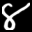

In [32]:
img_4 = Image.open(choice(fours.files))
img_4

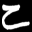

In [33]:
img_8 = Image.open(choice(eights.files))
img_8

Let's convert the images to numpy arrays, so we can check the shape etc. and also transform it to PyTorch tensors easily.

In [34]:
img_4_np = np.array(img_4)
img_8_np = np.array(img_8)

In [35]:
img_4_np.shape

(32, 32)

We can choose to see a slice of the multidimensional array by using the slice notation (on each axis)

In [36]:
img_4_np[10:15, 10:15]

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   8],
       [  0,   0,   2,  28, 131],
       [  0,   7,  61, 188, 253],
       [ 23, 117, 232, 255, 255]], dtype=uint8)

Next, we can convert the numpy array to pytorch tensor and see that everything still is the same. Obviouly, the container type is updated to the torch type.

In [37]:
torch.tensor(img_4_np).shape

torch.Size([32, 32])

In [38]:
torch.tensor(img_4_np)[10:15, 10:15]

tensor([[  0,   0,   0,   0,   0],
        [  0,   0,   0,   1,   8],
        [  0,   0,   2,  28, 131],
        [  0,   7,  61, 188, 253],
        [ 23, 117, 232, 255, 255]], dtype=torch.uint8)

Finally, let's convert a slice to a pandas dataframe, so that we can print a grid and colormap it with a gradient to visualise the numbers in each pixel.

In [39]:
df = pd.DataFrame(img_4_np[:24, :24])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,5,9,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,4,28,85,144,173,152,71,13,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,14,90,205,250,255,255,255,240,126,14,0,0,0,0,0,0,0,0,0,0,0
5,0,0,20,129,242,255,248,162,129,215,255,238,66,4,0,0,0,0,0,0,0,0,0,0
6,0,0,130,244,255,242,118,16,6,53,163,186,66,5,0,0,0,0,0,0,0,0,4,31
7,0,0,254,255,247,117,13,0,0,2,12,20,7,0,0,0,0,0,0,0,3,26,103,207
8,0,0,255,255,174,21,0,0,0,0,0,0,0,0,0,0,0,0,1,12,80,197,251,255
9,0,0,255,252,112,4,0,0,0,0,0,0,0,0,0,0,0,5,45,157,246,255,255,245


## Let's try out pixel similarity

### Calculate the average ४ (4) and average ८ (8)

Let's first convert all the images in training set to tensors.

In [40]:
four_tensors = [torch.tensor(np.array(Image.open(f))) for f in fours.files]
choice(four_tensors).shape

torch.Size([32, 32])

In [41]:
eight_tensors = [torch.tensor(np.array(Image.open(f))) for f in eights.files]
choice(eight_tensors).shape

torch.Size([32, 32])

Let's define a quick function to print the tensor.

In [42]:
def tshow(t):
    plt.imshow(t, cmap="gray")

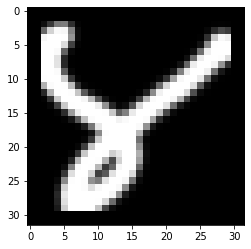

In [43]:
tshow(four_tensors[0])

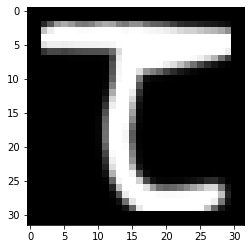

In [44]:
tshow(eight_tensors[0])

The next step is to stack all the tensors in a single tensor, convert them to float, and normalise them. Pixels when represented in float tend to be in the 0.0 - 1.0 range.

In [45]:
stacked_fours = torch.stack(four_tensors).float()/255
stacked_fours.shape

torch.Size([1700, 32, 32])

In [46]:
stacked_eights = torch.stack(eight_tensors).float()/255
stacked_eights.shape

torch.Size([1700, 32, 32])

Finally, let's calculate the average ४ and ८. We can do this by simply averaging the stack over the 0th axis. As you can see in the shape above, this is is the axis along which individual images are spread.

In [47]:
mean_four = stacked_fours.mean(0)
mean_four.shape

torch.Size([32, 32])

In [48]:
mean_eight = stacked_eights.mean(0)
mean_eight.shape

torch.Size([32, 32])

### Big reveal for the average ४ and ८

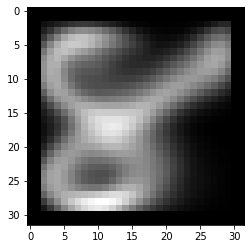

In [49]:
tshow(mean_four)

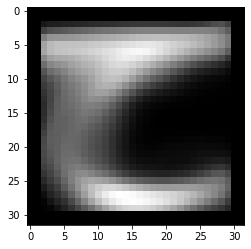

In [50]:
tshow(mean_eight)

## Distance from the average

Next, we can measure the distance(how similar) of a particular image from the average one. 

The main idea for similarity being that the lower the distance from a class average, the closer it is to that particular class.

We can do this in two different ways:
- Calculate the Mean Absolute Different (also know as L1 norm)
- Calculate the Root Mean Squared Error (also knows as L2 norm)

Let's pick a random sample from the stack and find it's distance/similarity

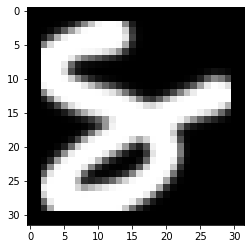

In [51]:
a_4 = stacked_fours[1]
a_8 = stacked_eights[1]

tshow(a_4)

In [52]:
dist_4_abs = (a_4 - mean_four).abs().mean()
dist_4_rmse = ((a_4 - mean_four)**2).mean().sqrt()

dist_4_abs, dist_4_rmse

(tensor(0.2466), tensor(0.3496))

PyTorch has builtin functions for these distances, all called losses. Let's use these loss function to calculate the distance of a sample from the two different averages.

In [53]:
F.l1_loss(a_4, mean_four), F.mse_loss(a_4, mean_four).sqrt()

(tensor(0.2466), tensor(0.3496))

In [54]:
F.l1_loss(a_4, mean_eight), F.mse_loss(a_4, mean_eight).sqrt()

(tensor(0.3533), tensor(0.4772))

We can see that the image for 4 is nearer to the average 4 compared to average 8, which should be the case.

## Accuracy of the mean digit on validation set

We use the same idea as mentioned above to calculate the accuracy of the mean digit. We have to make sure that we always measure accuracy on a dataset the model has not seen before.

We can finally use the validation set to measure the accuracy.

In [55]:
four_valid_tensors = [torch.tensor(np.array(Image.open(f))) for f in fours_valid.files]

In [56]:
eight_valid_tensors = [torch.tensor(np.array(Image.open(f))) for f in eights_valid.files]

In [57]:
stacked_fours_valid = torch.stack(four_valid_tensors).float()/255
stacked_fours_valid.shape

torch.Size([300, 32, 32])

In [58]:
stacked_eights_valid = torch.stack(eight_valid_tensors).float()/255
stacked_eights_valid.shape

torch.Size([300, 32, 32])

### Distance measurement

The validation set has 300 images each, which we convert to tensors.

We then measure the distance of each image by 
- taking the pixelwise difference with the average image (shape 32x32)
- getting the absolute of that value (shape 32x32)
- getting the mean along the last and second to last axis

Pytorch can easily broadcast this between two tensors of different ranks, so we can simply get the distance of the whole stack at once.

In [59]:
def dhcd_distance(a, b):
    return (a - b).abs().mean((-2, -1)) # mean across the second last and the last axis

In [60]:
dhcd_distance(stacked_fours_valid[3], mean_four)

tensor(0.2264)

In [61]:
dhcd_distance(stacked_fours_valid, mean_four).shape

torch.Size([300])

### Classification based on distance

Finally we can define a function to classify whether an image is ४ (4) or not based on the distances to the averge class value

In [62]:
def is_4(x):
    return dhcd_distance(x, mean_four) < dhcd_distance(x, mean_eight)

In [63]:
is_4(a_4), is_4(a_4).float()

(tensor(True), tensor(1.))

In [64]:
is_4(a_8), is_4(a_8).float()

(tensor(False), tensor(0.))

As we can see above the classifer does the job well. Now, let's test it on the entire validation set and see how accurate our model is.

In [65]:
is_4(stacked_fours_valid).shape

torch.Size([300])

### Accuracy on the validation set

In [66]:
accuracy_fours  =      is_4(stacked_fours_valid).float().mean()
accuracy_eights = (1 - is_4(stacked_eights_valid).float()).mean()

accuracy_fours, accuracy_eights, (accuracy_fours+accuracy_eights)/2

(tensor(0.9467), tensor(0.9933), tensor(0.9700))

As we can see above, the averaging pixel classifier is not really that bad to get started with.